## 1 - Packages

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.misc import derivative
import sklearn
from sklearn import datasets
import pandas as pd

plt.rcParams['figure.figsize'] = (8.0, 8.0) # definit la taille de figure plot
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [82]:
def relu(z):
    cache = z
    A = np.maximum(0, z)
    return A, cache
                
def relu_derivate(dA, activation_cache):
    z=activation_cache 
    dZ = np.array(dA, copy=True)
    dZ[z <= 0] = 0
    return dZ

In [83]:
def sigmoid(z):
    cache = z
    A=1/(1+np.exp(-z))
    return A, cache

def sigmoid_derivate(dA, activation_cache):
    z = activation_cache 
    s = 1/(1+np.exp(-z))
    dZ = dA * s * (1-s)
    return dZ
    

In [84]:
def initialisation(dimension_layer):
    parameters = {}
    L = len(dimension_layer)
    for l in range(1, L):
        ####question pq W1.shape ==> (4,13)
        parameters['W' + str(l)] = np.random.randn(dimension_layer[l], dimension_layer[l-1])*0.0251
        parameters['b' + str(l)] = np.zeros((dimension_layer[l],1))
    return parameters

In [85]:
def lineaire_forward(A, W,b):
    Z = np.dot(W,A) + b
    
    #assert(Z.shape == (W.shape[0], A.shape[1]))
    
    cache = (A, W, b)
    
    return Z, cache

In [86]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_cache=lineaire_forward(A_prev,W,b)
        A, activation_cache=sigmoid(Z)
        
    elif activation == "relu" :
        Z, linear_cache = lineaire_forward(A_prev,W,b)
        A, activation_cache=relu(Z)
        
    cache = (linear_cache, activation_cache)

    return A, cache

In [87]:
def model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1, L):
        A_prev = A 
        A,cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b'+str(l)], activation="relu")
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A, parameters['W'+str(L)] , parameters['b'+str(L)], activation="sigmoid")
    
    caches.append(cache)
   
    
    return AL, caches

In [88]:
def calcule_cost(AL, Y):
    m = Y.shape[1]
    
    #cost = -1./m * np.sum(Y*np.log(AL+0.1)+(1-Y)*np.log(abs(1-AL)+0.1))
    cost=(-1/m) * np.sum((Y*np.log(AL+0.1)+(1-Y)*np.log((1-AL)+0.1)))
    
    cost = np.squeeze(cost)
    cost = abs(cost)
    return cost

In [89]:
def linear_backword(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW=1./m*(np.dot(dZ,A_prev.T))
    db=1./m*(np.sum(dZ, axis=1, keepdims=True))
    dA_prev=np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [90]:
def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache= cache
    
    if activation == "relu":
            
        dZ=relu_derivate(dA,activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)
        
        
    elif activation == "sigmoid":

        dZ=sigmoid_derivate(dA,activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)
        
    return dA_prev, dW, db

In [91]:
def model_backward(AL, Y, caches):
    
    gradients = {}
    L = len(caches) #le nombre des couches layers
    m = AL.shape[1]
    #Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, (1 - AL)))
    
    current_cache=caches[L-1]
    
    dA_prev, dW, db = linear_activation_backward(dAL, current_cache,activation="sigmoid")
    
    gradients["dA"+ str(L-1)]=dA_prev
    gradients["dW"+ str(L)]=dW
    gradients["db"+ str(L)]=db
    
    for l in reversed(range(L-1)):
        
        current_cache=caches[l]
        dA_prev, dW, db = linear_activation_backward(gradients["dA"+ str(l+1)], current_cache, activation = "relu")
    
        gradients["dA"+ str(l)]=dA_prev
        gradients["dW"+ str(l+1)]=dW
        gradients["db"+ str(l+1)]=db
    
    return gradients

In [92]:
## n'est pas utilisé :

def miseajours_poids(parameters, gradients, learning_rate):
    
    L = len(parameters) // 2
    
    for l in range(L):
        parameters["W"+ str(l+1)]=parameters["W"+ str(l+1)]-learning_rate*gradients["dW"+ str(l+1)]
        parameters["b"+ str(l+1)]=parameters["b"+ str(l+1)]-learning_rate*gradients["db"+ str(l+1)]

    return parameters

In [93]:
def Modelgenerale(X, Y, dimension_layer, learning_rate = 0.075, num_iterations = 10000):
    parameters=initialisation(dimension_layer)
    costs = []
    
    for i in range(0, num_iterations):
        
        AL, caches = model_forward(X, parameters)
        cout = calcule_cost(AL, Y)
        
        if i % 1000 == 0:
            costs.append(cout)
        
        gradients=model_backward(AL, Y, caches)
        parameters=miseajours_poids(parameters, gradients, learning_rate)
                 
    return parameters, costs

In [94]:
def Modelpredict(X, parameters):
    m = X.shape[1]

    # number of layers in the neural network
    n = len(parameters) // 2
    p = np.zeros((1,m))
    
    probas, caches = model_forward(X, parameters)

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0   
        
    return p

## DataSet BREAST_CANCER

In [95]:
from sklearn.datasets import load_breast_cancer

In [96]:
cancer = load_breast_cancer()

In [97]:
df = pd.DataFrame(cancer.data, columns = [cancer.feature_names])
df['target']= pd.Series(data=cancer.target, index=df.index)

In [98]:
x=df.iloc[0:,0:30]
y=df['target']

In [99]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test=train_test_split(x,y,train_size=426,test_size=143)


In [100]:
x_train=x_train.T
y_train=y_train.T

x_test=x_test.T
y_test=y_test.T

In [101]:
x_train=x_train.to_numpy()
y_train=y_train.to_numpy()
x_test= x_test.to_numpy()
y_test=y_test.to_numpy()

In [102]:
layers_dims = [30, 10, 5, 1]

parameters, cousts = Modelgenerale(x_train, y_train, layers_dims, learning_rate = 0.2, num_iterations = 15000)

In [103]:
cousts

[0.5108256237659906,
 0.4743736234977778,
 0.4743736234977778,
 0.4743736234977778,
 0.4743736234977778,
 0.4743736234977778,
 0.4743736234977778,
 0.4743736234977778,
 0.4743736234977778,
 0.4743736234977778,
 0.4743736234977778,
 0.4743736234977778,
 0.4743736234977778,
 0.4743736234977778,
 0.4743736234977778]

In [104]:
y_test.shape

(1, 143)

In [105]:
ypred = Modelpredict(x_test, parameters)

In [106]:
ypred

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [107]:
y_test

array([[1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]])

In [108]:
c=calcule_cost(ypred, y_test)
c

0.8604942296327875

## /-  Other dataset generer : Par make_classification en Sklearn

In [144]:
from sklearn.datasets import make_classification

In [156]:
x, y = make_classification(n_samples=100,n_features=10, random_state=1)

In [157]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, stratify=y, random_state=0)

xtrain=xtrain.T
xtest=xtest.T

ytrain=np.array(ytrain).reshape(1, ytrain.shape[0])
ytest=np.array(ytest).reshape(1, ytest.shape[0])

In [158]:
layers_dims = [10, 10, 5, 1]

parameters, cousts = Modelgenerale(xtrain, ytrain, layers_dims, learning_rate = 0.2, num_iterations = 6000)

In [159]:
ypred=Modelpredict(xtest, parameters)

In [160]:
cousts

[0.5108154675507628,
 0.09354957487911296,
 0.09491584886592298,
 0.09510151774358976,
 0.09517311504159477,
 0.0952098726660649]

In [161]:
ytest.shape

(1, 25)

In [162]:
costtest=calcule_cost(ypred, ytest)

In [163]:
costtest

0.09652144201954471

In [164]:
ypred

array([[1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0.,
        1., 1., 0., 0., 0., 0., 1., 1., 1.]])

In [166]:
ytest

array([[1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 1]])

In [167]:
np.abs(ytest-ypred)

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0.]])

# Génerer autre dataSet par make_blobs

In [135]:
from sklearn.datasets import make_blobs
X, Y = make_blobs(n_samples=500, centers=2, n_features=2)

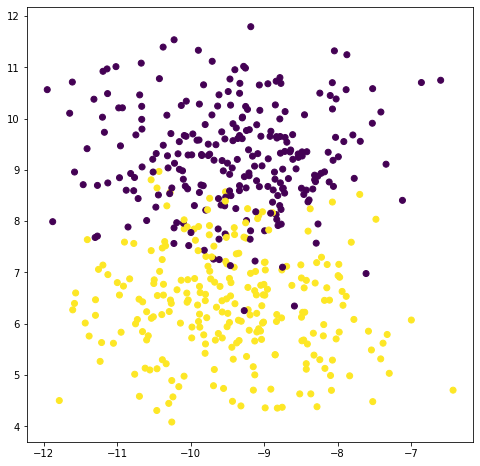

In [136]:
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis')

In [137]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, stratify=Y, random_state=1)

In [138]:
xtrain=xtrain.T
xtest=xtest.T

ytrain=np.array(ytrain).reshape(1, ytrain.shape[0])
ytest=np.array(ytest).reshape(1, ytest.shape[0])

In [139]:
layers_dims = [2, 5,5, 1]

parameters, cousts = Modelgenerale(xtrain, ytrain, layers_dims, learning_rate = 0.2, num_iterations = 6000)

In [140]:
ypred=Modelpredict(xtest, parameters)

In [141]:
ypred

array([[1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
        0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
        0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0.]])

In [142]:
calcule_cost(ypred, ytest)

0.15407092856670557